# Laboratorio 1
### Security Data Science
- Christian Pérez
- Andrei Portales

In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

In [3]:
df = pd.read_csv('dataset_pishing.csv')
df.head()

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [4]:
df['status'].value_counts()


legitimate    5715
phishing      5715
Name: status, dtype: int64

Funciones para detectar pishing:
- longitud del hostname y URL completa
- Caracteres especiales en los dominios y subdominios
- No contar con certificado SSL
- Muchos numeros en las URL

In [5]:
from urllib.parse import urlparse

# Function to get lenght of URL
def get_url_length(url):
    return len(url)

def get_hostname_length(url):
    return len(urlparse(url).netloc)

# Funtion to get if https is present in URL
def get_https(url):
    if 'https' in url:
        return 1
    else:
        return 0

# Function to get if there are the following characters in URL: ., -, @, /, ?, &, |, =, _, ~, #, %, $, :, *, ,, ;, , %%!
def get_special_characters(url):
    if re.search(r'[.,@/?&|=~#%$:*;,! ]', url):
        return 0
    else:
        return 1

# Function to get number of digits in URL
def get_digits(url):
    return len(re.findall(r'\d', url))

# Function to get number of digits in hostname
def get_digits_hostname(url):
    return len(re.findall(r'\d', urlparse(url).netloc))


In [6]:
new_df = df.copy()
new_df['url_length'] = new_df['url'].apply(get_url_length)
new_df['hostname_length'] = new_df['url'].apply(get_hostname_length)
new_df['https'] = new_df['url'].apply(get_https)
new_df['special_characters'] = new_df['url'].apply(get_special_characters)
new_df['digits'] = new_df['url'].apply(get_digits)
new_df['digits_hostname'] = new_df['url'].apply(get_digits_hostname)
df_all = new_df.copy()
new_df.head()


,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,dns_record,google_index,page_rank,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,1,1,4,legitimate,37,19,0,0,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,0,1,2,phishing,77,23,0,0,17,0
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,0,1,0,phishing,126,50,1,0,19,0
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,0,0,3,legitimate,18,11,0,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,0,6,legitimate,55,15,0,0,0,0


In [7]:
# Change the values of the status column to 0 and 1
new_df['status'] = new_df['status'].map({'legitimate': 1, 'phishing': 0})
new_df.head()

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,dns_record,google_index,page_rank,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,1,1,4,1,37,19,0,0,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,0,1,2,0,77,23,0,0,17,0
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,0,1,0,0,126,50,1,0,19,0
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,0,0,3,1,18,11,0,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,0,6,1,55,15,0,0,0,0


In [8]:
# Delete the url column
new_df = new_df.drop('url', axis=1)
new_df.head()

,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,...,dns_record,google_index,page_rank,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,0,1,0,0,0,0,0,0,0,0,...,1,1,4,1,37,19,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,2,0,77,23,0,0,17,0
2,1,0,1,0,0,0,0,0,1,0,...,0,1,0,0,126,50,1,0,19,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,3,1,18,11,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,6,1,55,15,0,0,0,0


In [9]:
import pandas_profiling
# save the report to a html file
pandas_profiling.ProfileReport(new_df).to_file('report.html')



In [10]:
# mostrar columnas
new_df.columns

Index(['ip', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'punycode',
       'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain',
       'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 'nb_hyperlinks', 'ratio_intHyperlinks',
       'ratio_extHyperlinks', 'ratio_nullHyperlinks', 'nb_extCSS',
       'ratio_intRedirection', 'ratio_extRedirection', 'ratio_intErrors',
       'ratio_extErrors', 'login_form', 'external_favicon', 'links_in_tags',
       'submit_email', 'ratio_intMedia', 'ratio_extMedia', 'sfh', 'iframe',


In [11]:
new_df.corr()['status'].sort_values(ascending=False).head(10)

status                   1.000000
page_rank                0.511137
nb_www                   0.443468
nb_hyperlinks            0.342628
domain_age               0.331889
ratio_intHyperlinks      0.243982
ratio_intMedia           0.193333
links_in_tags            0.184401
safe_anchor              0.173397
domain_with_copyright    0.173098
Name: status, dtype: float64

In [12]:
# show the 10 most correlated features
new_df.corr()['status'].sort_values(ascending=True).head(20)


google_index         -0.731171
domain_in_title      -0.342807
phish_hints          -0.335393
ip                   -0.321698
url_length           -0.248482
digits               -0.240425
hostname_length      -0.238516
shortest_word_host   -0.223084
digits_hostname      -0.220632
prefix_suffix        -0.214681
longest_word_path    -0.212709
tld_in_subdomain     -0.208884
empty_title          -0.207043
longest_words_raw    -0.200147
avg_word_path        -0.197256
avg_word_host        -0.193502
length_words_raw     -0.192010
avg_words_raw        -0.167564
nb_com               -0.156284
statistical_report   -0.143944
Name: status, dtype: float64

In [13]:
df2 = new_df[['page_rank', 'nb_www', 'nb_hyperlinks', 'domain_age', 'ratio_intHyperlinks', 'google_index', 'domain_in_title', 'phish_hints', 'ip', 'prefix_suffix', 'longest_word_path','status', 'url_length', 'hostname_length', 'https', 'special_characters', 'digits', 'digits_hostname']]
df2.head()

,page_rank,nb_www,nb_hyperlinks,domain_age,ratio_intHyperlinks,google_index,domain_in_title,phish_hints,ip,prefix_suffix,longest_word_path,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,4,1,17,-1,0.529412,1,0,0,0,0,6,1,37,19,0,0,0,0
1,2,0,30,5767,0.966667,1,1,0,1,0,32,0,77,23,0,0,17,0
2,0,0,4,4004,1.000000,1,1,0,1,1,17,0,126,50,1,0,19,0
3,3,0,149,-1,0.973154,0,1,0,0,0,0,1,18,11,0,0,0,0
4,6,1,102,8175,0.470588,0,0,0,0,0,11,1,55,15,0,0,0,0


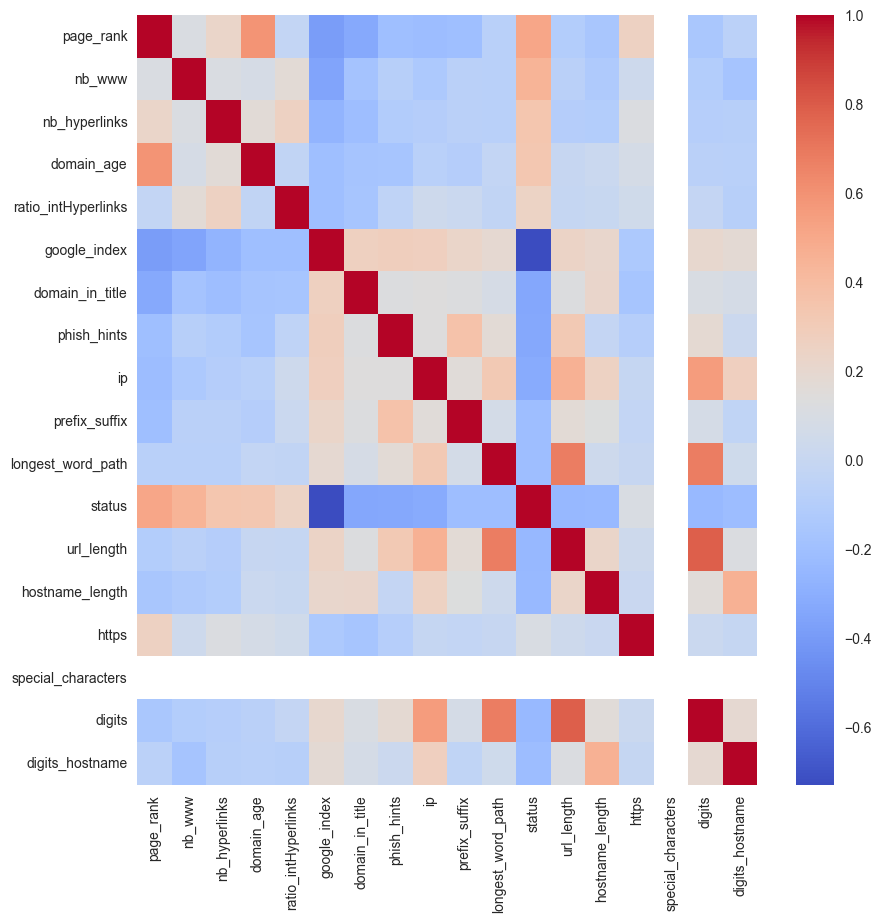

In [14]:
corr = df2.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, fmt='.2f', cmap='coolwarm')
plt.show()

In [15]:
# new dataframe with only status, url_length, hostname_length, https, special_characters, digits and digits_hostname
df3 = new_df[['status', 'url_length', 'hostname_length', 'https', 'special_characters', 'digits', 'digits_hostname']]
df3.head()

,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,1,37,19,0,0,0,0
1,0,77,23,0,0,17,0
2,0,126,50,1,0,19,0
3,1,18,11,0,0,0,0
4,1,55,15,0,0,0,0


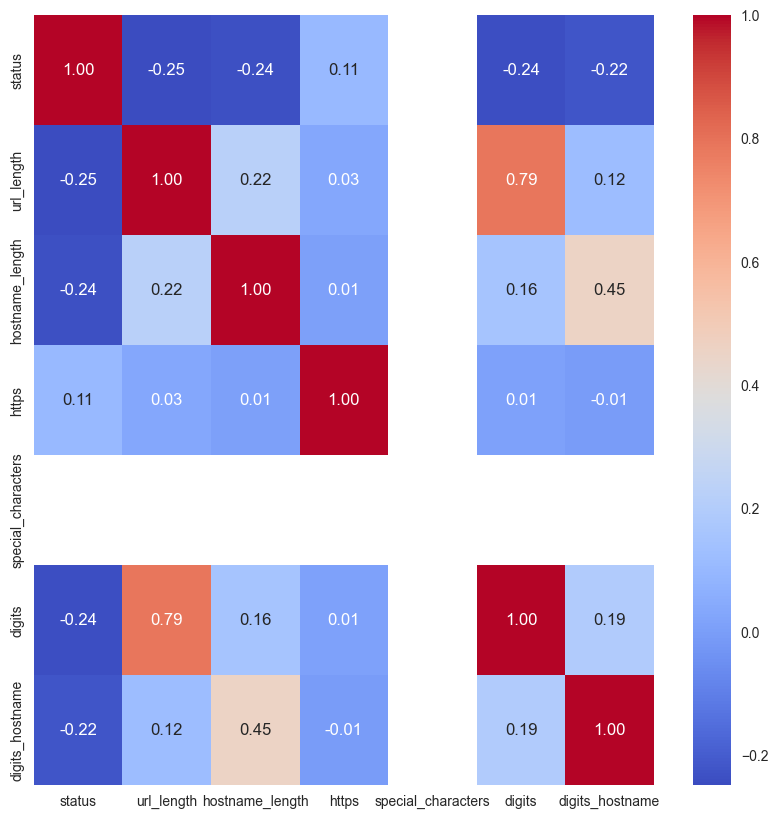

In [16]:
# Draw a heatmap with the correlation matrix
corr = df3.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [17]:
df2.head()

,page_rank,nb_www,nb_hyperlinks,domain_age,ratio_intHyperlinks,google_index,domain_in_title,phish_hints,ip,prefix_suffix,longest_word_path,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,4,1,17,-1,0.529412,1,0,0,0,0,6,1,37,19,0,0,0,0
1,2,0,30,5767,0.966667,1,1,0,1,0,32,0,77,23,0,0,17,0
2,0,0,4,4004,1.000000,1,1,0,1,1,17,0,126,50,1,0,19,0
3,3,0,149,-1,0.973154,0,1,0,0,0,0,1,18,11,0,0,0,0
4,6,1,102,8175,0.470588,0,0,0,0,0,11,1,55,15,0,0,0,0


### Modelo con RandomForestClassifier

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

labels = df2['status']
features = df2.drop('status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.39%


In [19]:
# matrix de confusion
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1616,   81],
       [  77, 1655]], dtype=int64)

In [20]:
# precision
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.9533410138248848

In [21]:
# recall
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.9555427251732102

In [22]:
# F1 Score 
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.9544405997693194

In [23]:
row_1 = df2.iloc[0]

features = df2.drop('status', axis=1)

# predict the status of the first row
model.predict([row_1.drop('status')])[0]

c:\Users\Christian\Documents\python_env\data_sciece_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1

In [24]:
columns = ['url','page_rank', 'nb_www', 'nb_hyperlinks', 'domain_age', 'ratio_intHyperlinks', 'google_index', 'domain_in_title', 'phish_hints', 'ip', 'prefix_suffix', 'longest_word_path','status', 'url_length', 'hostname_length', 'https', 'special_characters', 'digits', 'digits_hostname']
df_ne = df_all[columns]
df_ne.head()

,url,page_rank,nb_www,nb_hyperlinks,domain_age,ratio_intHyperlinks,google_index,domain_in_title,phish_hints,ip,prefix_suffix,longest_word_path,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,http://www.crestonwood.com/router.php,4,1,17,-1,0.529412,1,0,0,0,0,6,legitimate,37,19,0,0,0,0
1,http://shadetreetechnology.com/V4/validation/a...,2,0,30,5767,0.966667,1,1,0,1,0,32,phishing,77,23,0,0,17,0
2,https://support-appleld.com.secureupdate.duila...,0,0,4,4004,1.000000,1,1,0,1,1,17,phishing,126,50,1,0,19,0
3,http://rgipt.ac.in,3,0,149,-1,0.973154,0,1,0,0,0,0,legitimate,18,11,0,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,6,1,102,8175,0.470588,0,0,0,0,0,11,legitimate,55,15,0,0,0,0


In [25]:
# columns with no status and url
columns = ['page_rank', 'nb_www', 'nb_hyperlinks', 'domain_age', 'ratio_intHyperlinks', 'google_index', 'domain_in_title', 'phish_hints', 'ip', 'prefix_suffix', 'longest_word_path','url_length', 'hostname_length', 'https', 'special_characters', 'digits', 'digits_hostname']

features = df_ne[columns]
df_ne['status_predicted'] = model.predict(features)
df_ne['status'] = df_all['status']
df_ne['status'] = df_ne['status'].map({'legitimate': 1, 'phishing': 0})
df_ne['url'] = df_all['url']

df_ne[['url', 'status', 'status_predicted']].head(50)

# save the dataframe to a csv file
df_ne[['url', 'status', 'status_predicted']].to_csv('df_predictions.csv', index=False)

C:\Users\Christian\AppData\Local\Temp\ipykernel_11904\289748688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ne['status_predicted'] = model.predict(features)
C:\Users\Christian\AppData\Local\Temp\ipykernel_11904\289748688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ne['status'] = df_all['status']
C:\Users\Christian\AppData\Local\Temp\ipykernel_11904\289748688.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

### Modelo con DecisionTreeClassifier

In [26]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1697
           1       0.93      0.93      0.93      1732

    accuracy                           0.93      3429
   macro avg       0.93      0.93      0.93      3429
weighted avg       0.93      0.93      0.93      3429



In [28]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1582  115]
 [ 115 1617]]


In [29]:
columns = ['url','page_rank', 'nb_www', 'nb_hyperlinks', 'domain_age', 'ratio_intHyperlinks', 'google_index', 'domain_in_title', 'phish_hints', 'ip', 'prefix_suffix', 'longest_word_path','status', 'url_length', 'hostname_length', 'https', 'special_characters', 'digits', 'digits_hostname']
df_ne = df_all[columns]
df_ne.head()

,url,page_rank,nb_www,nb_hyperlinks,domain_age,ratio_intHyperlinks,google_index,domain_in_title,phish_hints,ip,prefix_suffix,longest_word_path,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,http://www.crestonwood.com/router.php,4,1,17,-1,0.529412,1,0,0,0,0,6,legitimate,37,19,0,0,0,0
1,http://shadetreetechnology.com/V4/validation/a...,2,0,30,5767,0.966667,1,1,0,1,0,32,phishing,77,23,0,0,17,0
2,https://support-appleld.com.secureupdate.duila...,0,0,4,4004,1.000000,1,1,0,1,1,17,phishing,126,50,1,0,19,0
3,http://rgipt.ac.in,3,0,149,-1,0.973154,0,1,0,0,0,0,legitimate,18,11,0,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,6,1,102,8175,0.470588,0,0,0,0,0,11,legitimate,55,15,0,0,0,0


In [31]:
# columns with no status and url
columns = ['page_rank', 'nb_www', 'nb_hyperlinks', 'domain_age', 'ratio_intHyperlinks', 'google_index', 'domain_in_title', 'phish_hints', 'ip', 'prefix_suffix', 'longest_word_path','url_length', 'hostname_length', 'https', 'special_characters', 'digits', 'digits_hostname']

features = df_ne[columns]
df_ne['status_predicted'] = clf.predict(features)
df_ne['status'] = df_all['status']
df_ne['status'] = df_ne['status'].map({'legitimate': 1, 'phishing': 0})
df_ne['url'] = df_all['url']

df_ne[['url', 'status', 'status_predicted']].head(50)

# save the dataframe to a csv file
df_ne[['url', 'status', 'status_predicted']].to_csv('df_predictions2.csv', index=False)

C:\Users\Christian\AppData\Local\Temp\ipykernel_11904\1929181373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ne['status_predicted'] = clf.predict(features)
C:\Users\Christian\AppData\Local\Temp\ipykernel_11904\1929181373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ne['status'] = df_all['status']
C:\Users\Christian\AppData\Local\Temp\ipykernel_11904\1929181373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col